# Rossman Store Sale

- Predict Daily Sale for a retail store Rossman
- Expan and modify from Jovian Data Science 
- https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/gradient-boosting-with-xgboost
- **Expand: Data Visulization**
- **Modify: Hyperparameter Tunning**
- Kaggle submission score is 0.146 

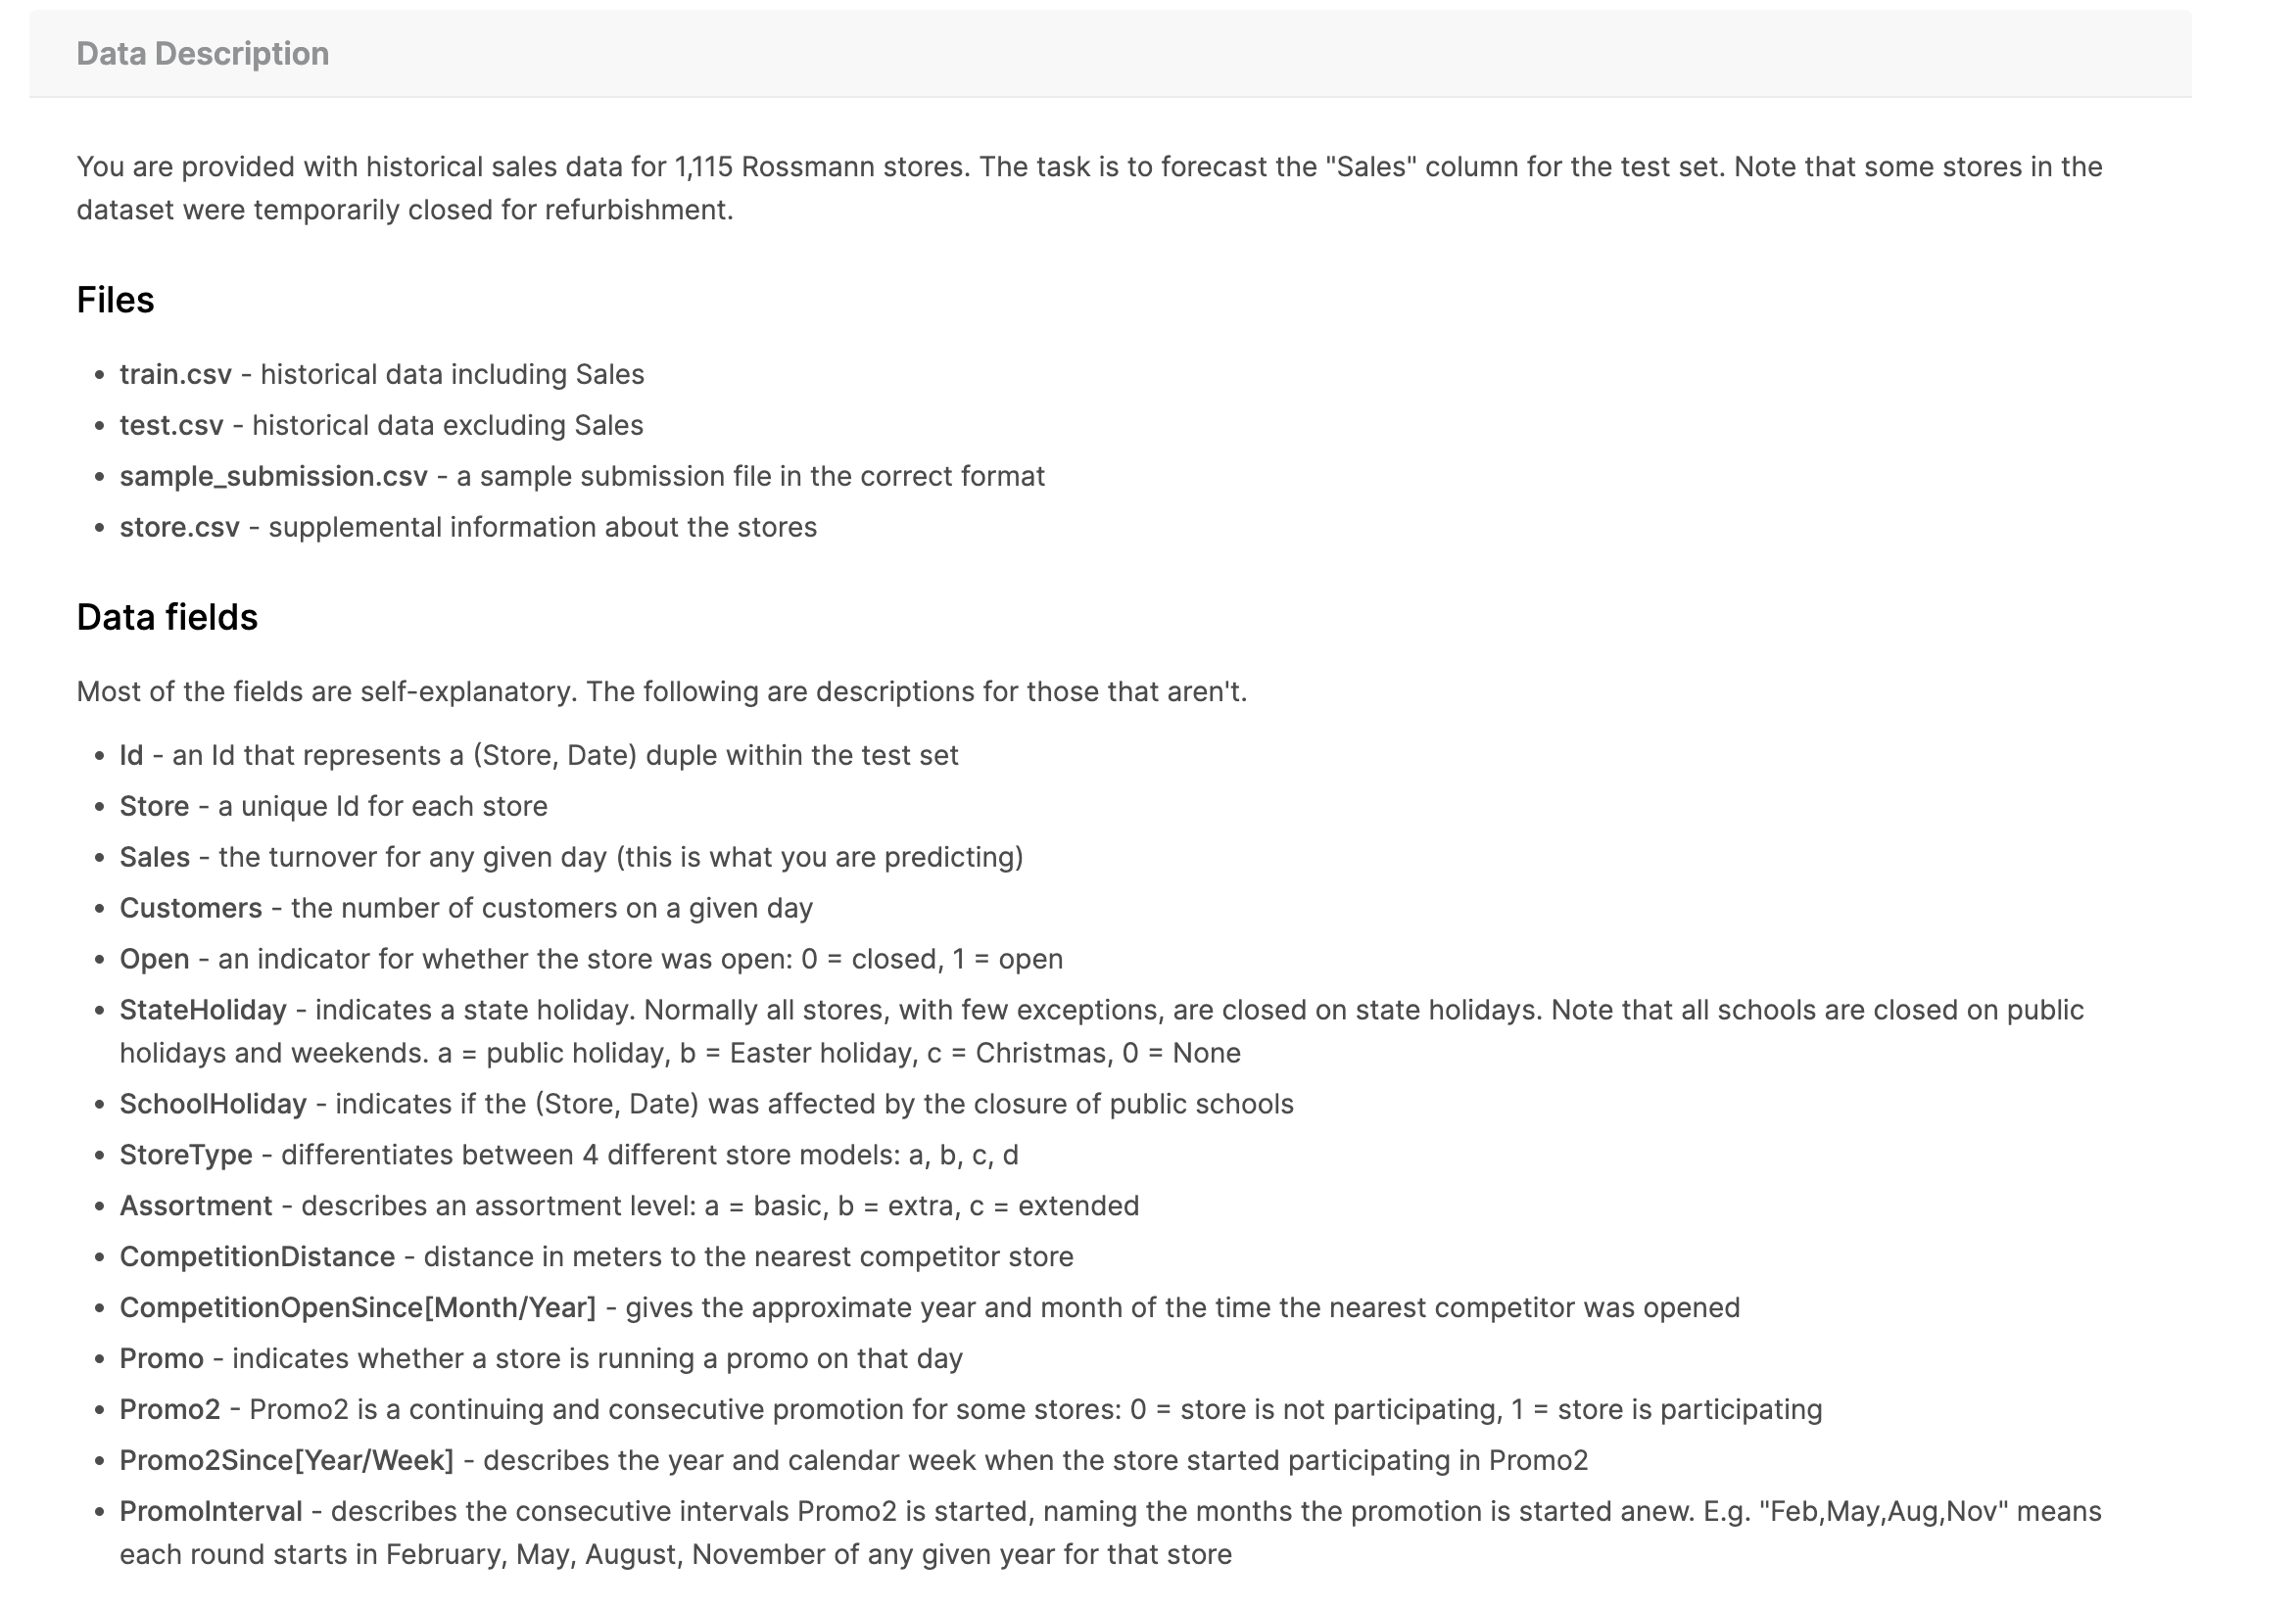

In [1]:
!pip install xgboost  --upgrade --quiet

In [2]:
import xgboost as xgb

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
xgb.__version__

'1.5.0'

In [4]:
!pip list | grep xgboost

xgboost                       1.6.1


In [5]:
from xgboost import XGBRegressor

In [6]:
!pip install opendatasets --upgrade --quiet

In [204]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 10)

In [205]:
ross_df = pd.read_csv('train.csv',low_memory=False)
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [22]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [23]:
ross_df["StateHoliday"].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

- https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

In [26]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [27]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [28]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [29]:
min(ross_df["Date"])

'2013-01-01'

In [30]:
max(ross_df["Date"])

'2015-07-31'

In [31]:
min(test_df["Date"])

'2015-08-01'

In [32]:
max(test_df["Date"])

'2015-09-17'

- **Training set from 2013 to July 2015**
- **Testing set August-September 2015**

## Exploratory Data Analysis

In [33]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (14,6)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

In [34]:
ross_df_viz = ross_df.copy()

In [35]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])    # convert the date column into datetime column
    df['Year'] = df.Date.dt.year               # then extract year, month, day, week
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [36]:
split_date(ross_df_viz)

In [37]:
#ross_df_viz

### Want to see all store sales each day

In [38]:
#ross_df_viz.info()

In [39]:
ross_df_viz = ross_df_viz.astype({"Date":"datetime64"})

In [40]:
#ross_df_viz.info()

In [41]:
ross_df_viz

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1


In [44]:
Open_1 = ross_df_viz["Open"]==1

In [45]:
Open_0 = ross_df_viz["Open"]==0

In [46]:
ross_df_viz[Open_1]["Sales"].describe()

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

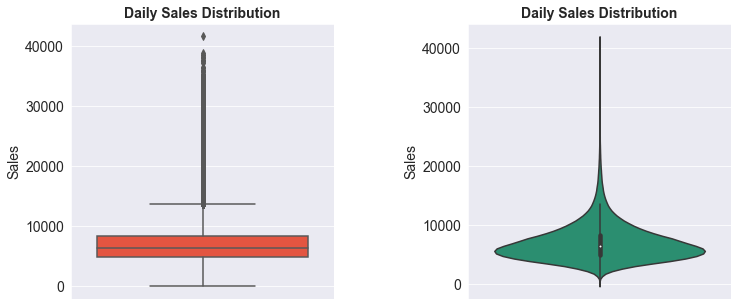

In [47]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].set_title("Daily Sales Distribution",fontdict= {'fontweight':'bold',"fontsize":14})
sns.boxplot(ax=axes[0], data = ross_df_viz[Open_1],  y=ross_df_viz[Open_1]["Sales"],palette="CMRmap")

axes[1].set_title("Daily Sales Distribution", fontdict= {'fontweight':'bold',"fontsize":14})
sns.violinplot(ax=axes[1], data=ross_df_viz[Open_1],  y=ross_df_viz[Open_1]["Sales"],palette="Dark2")

plt.tight_layout(pad=5)

[Text(0.5, 1.0, 'Daily Sales are about 5,000-6,000')]

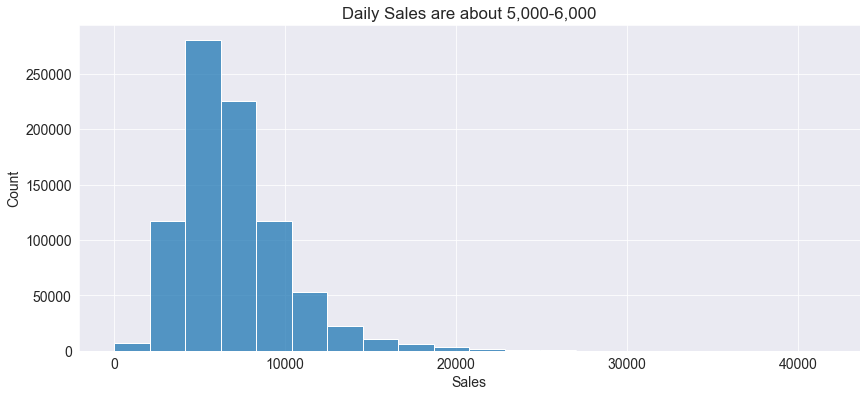

In [48]:
sns.histplot(data=ross_df_viz[Open_1], x="Sales", bins=20).set(title="Daily Sales are about 5,000-6,000")

[Text(0.5, 1.0, 'Daily Customers are about 500-600')]

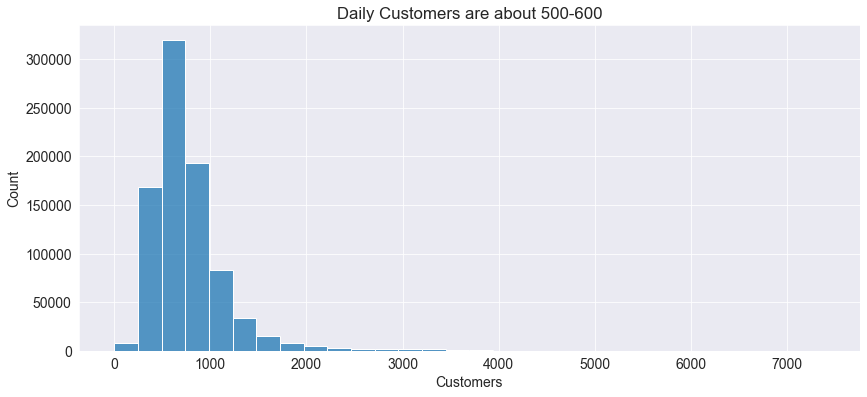

In [49]:
sns.histplot(data=ross_df_viz[Open_1], x="Customers", bins=30).set(title="Daily Customers are about 500-600")

In [50]:
df_2015 = ross_df_viz[ross_df_viz["Date"].dt.year==2015]
df_2014 = ross_df_viz[ross_df_viz["Date"].dt.year==2014]
df_2013 = ross_df_viz[ross_df_viz["Date"].dt.year==2013]

In [51]:
df_2013_monthly = df_2013.groupby(["Month"])["Sales"].sum().to_frame()
df_2014_monthly = df_2014.groupby(["Month"])["Sales"].sum().to_frame()
df_2015_monthly = df_2015.groupby(["Month"])["Sales"].sum().to_frame()

[Text(0.5, 1.0, '2013 Sales by Month')]

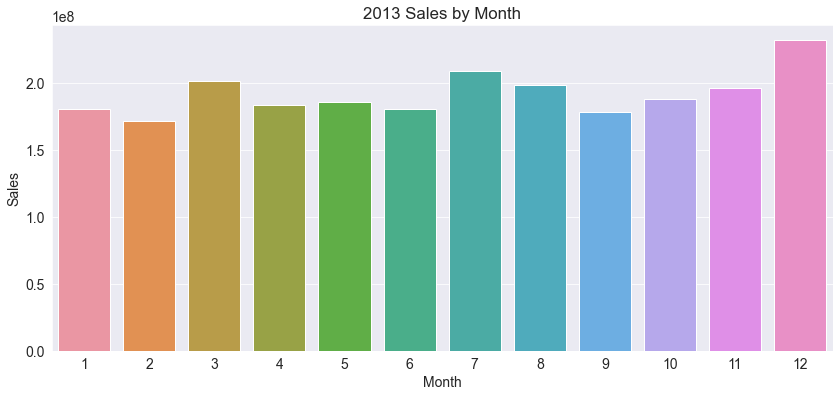

In [52]:
sns.barplot(data = df_2013_monthly, x = df_2013_monthly.index, y="Sales").set(title="2013 Sales by Month")

[Text(0.5, 1.0, '2014 Sales by Month')]

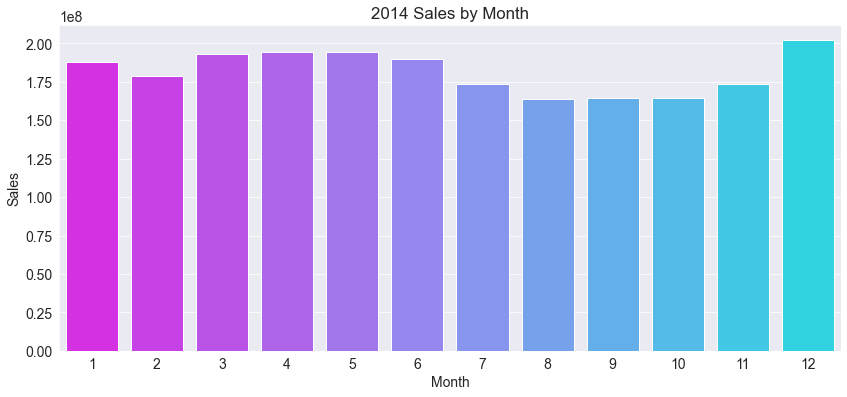

In [53]:
sns.barplot(data = df_2014_monthly, x = df_2014_monthly.index, y="Sales",palette="cool_r").set(title="2014 Sales by Month")


[Text(0.5, 1.0, '2015 Sales by Months')]

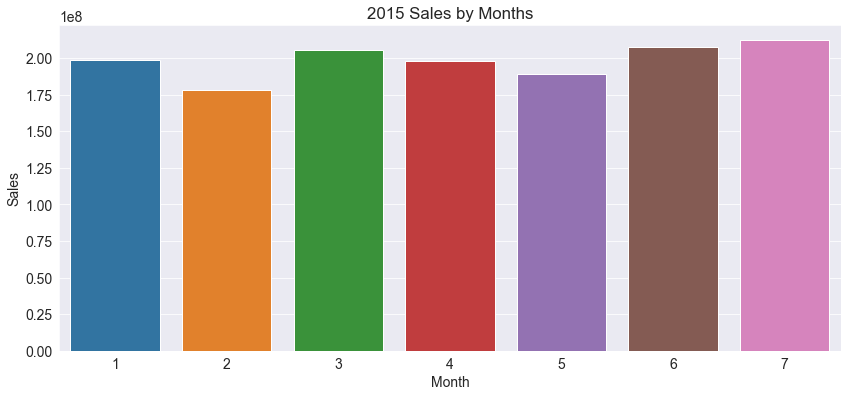

In [54]:
sns.barplot(data = df_2015_monthly, x = df_2015_monthly.index, y="Sales").set(title="2015 Sales by Months")

In [55]:
ross_df_viz[Open_1]["DayOfWeek"].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [56]:
dayOfweek = ross_df_viz[Open_1].groupby(["DayOfWeek"])["Sales"].mean().to_frame()
dayOfweek

,Sales
DayOfWeek,
1,8216.073074
2,7088.113656
3,6728.122978
4,6767.310159
5,7072.677012
6,5874.840238
7,8224.723908


[Text(0.5, 1.0, 'Average Sales by DayOfWeek')]

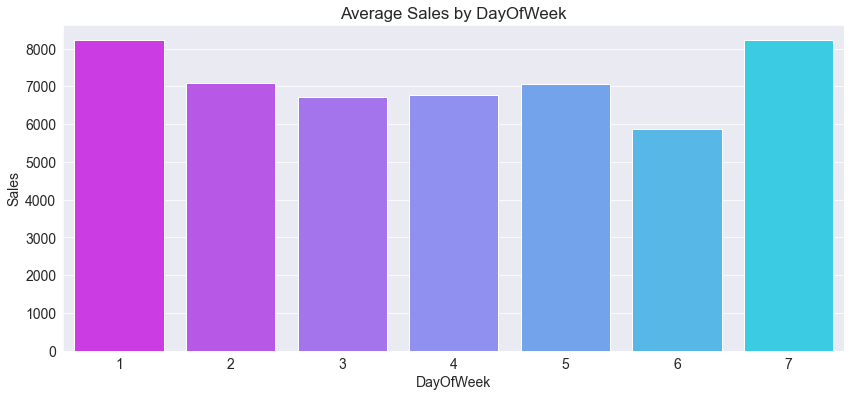

In [57]:
sns.barplot(data=dayOfweek, x=dayOfweek.index, y="Sales",palette="cool_r").set(title="Average Sales by DayOfWeek")

In [58]:
ross_df_viz[Open_1]["Day"].unique()

array([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [59]:
dayOfmonth = ross_df_viz[Open_1].groupby(["Day"])["Sales"].mean().to_frame()
dayOfmonth

,Sales
Day,
1,8053.674102
2,7987.452335
3,7765.296991
4,7745.844134
5,7554.982112
...,...
27,6636.996208
28,6943.025241
29,7512.799109


[Text(0.5, 1.0, 'Average Sales by Day Of Month')]

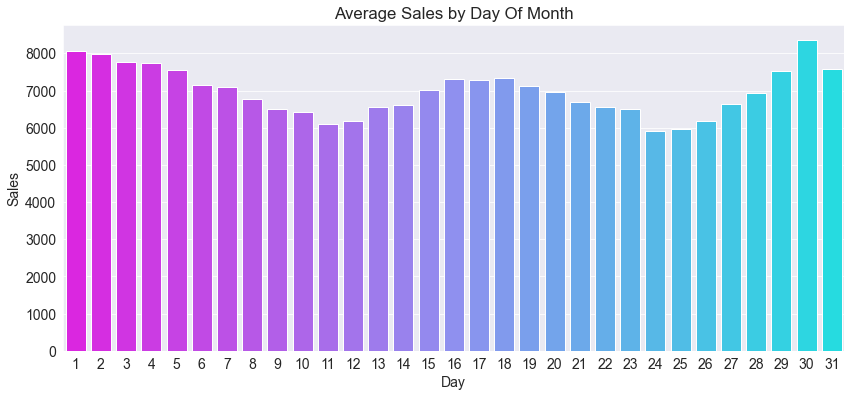

In [60]:
sns.barplot(data=dayOfmonth, x=dayOfmonth.index, y="Sales",palette="cool_r").set(title="Average Sales by Day Of Month")

In [61]:
sum_daily_sale = ross_df_viz[Open_1].groupby("Date")["Sales"].sum().to_frame()
sum_daily_sale

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593
...,...
2015-07-27,10707292
2015-07-28,9115073
2015-07-29,8499962


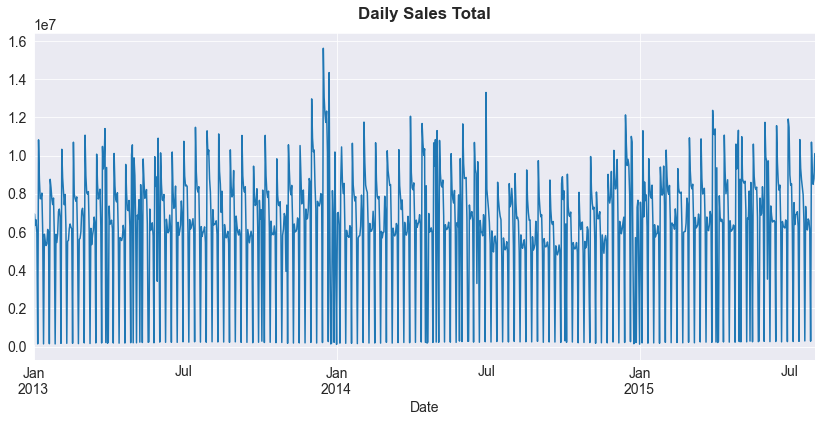

In [62]:
sum_daily_sale['Sales'].plot() 
plt.title("Daily Sales Total", fontweight="bold", y=1.025)
plt.show()

## Data Preprocessing

### Merge Datasets

In [63]:
merged_df = ross_df.merge(store_df, how='left', on='Store')      # keep all rows on ross_df (daily sale)
merged_test_df = test_df.merge(store_df, how='left', on='Store') # keep all dates from test set for submission

In [64]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Add Features

#### Date

In [65]:
split_date(merged_df)
split_date(merged_test_df)

In [66]:
merged_df.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31


In [67]:
merged_df.tail(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1


#### Open

- Remove the rows(days) where stores were not open

In [68]:
len(merged_df)

1017209

In [69]:
merged_df[merged_df["Open"]==0]["Sales"].value_counts()

0    172817
Name: Sales, dtype: int64

In [70]:
merged_df = merged_df[merged_df["Open"]==1].copy()

In [71]:
len(merged_df) # now the dataset shriks to 800,000 rows from 1 million row

844392

#### Competition

- We want to **make a new feature**. **How many months a compettitor is, 'CompetitionOpen'**
- Using column "Date" minus columns "CompettitionOpenSinceYear" and "CompetitionOpenSinceMonth"
- If a competitor occured after a particulare date of the store daily sale, we will exclude this data, 
- and replace with value 0
- If there's no competition, the value is NaN, we will also replace with 0

In [72]:
merged_df[['Date','CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].sample(20, random_state=1)


,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth
380760,2014-07-30,520.0,2009.0,3.0
868349,2013-05-14,50.0,2015.0,6.0
51885,2015-06-15,290.0,2006.0,9.0
552309,2014-02-21,720.0,2004.0,11.0
151676,2015-03-17,4230.0,2014.0,12.0
...,...,...,...,...
883591,2013-04-30,1390.0,NaN,NaN
804595,2013-07-10,5290.0,2012.0,11.0
386865,2014-07-24,3230.0,2011.0,11.0
892468,2013-04-22,1700.0,2008.0,1.0


In [73]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    
    # the 2nd line is when there's no competition store open yet, so we will replace this value with 0
    # also if the competition store will be open in the future year, which will make the 1st line calculation to be negative value,
    # we will replace it with 0 also
    

In [74]:
comp_months(merged_df)
comp_months(merged_test_df)

In [75]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20, random_state=1)


,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
380760,2014-07-30,520.0,2009.0,3.0,64.0
868349,2013-05-14,50.0,2015.0,6.0,0.0
51885,2015-06-15,290.0,2006.0,9.0,105.0
552309,2014-02-21,720.0,2004.0,11.0,111.0
151676,2015-03-17,4230.0,2014.0,12.0,3.0
...,...,...,...,...,...
883591,2013-04-30,1390.0,NaN,NaN,0.0
804595,2013-07-10,5290.0,2012.0,11.0,8.0
386865,2014-07-24,3230.0,2011.0,11.0,32.0
892468,2013-04-22,1700.0,2008.0,1.0,63.0


#### Promotion

- We want to **make new features** from promotion data
- 1. Is a store **is having a promotion running the current month**
- 2. If yes, **how long the promotion has been running, in months**


- "Promo2" indicates if a store is running a recurring promotion or not
- If it's 1, there will be values in "Promo2SincYear", "Promo2SinceWeek", "PromoInterval"
- If it's 0, these columns values will be NaN

In [76]:
merged_df[['Date', "Year",'WeekOfYear','Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 
           'PromoInterval']].sample(20, random_state=6)

,Date,Year,WeekOfYear,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval
142801,2015-03-25,2015,13,1,2009.0,37.0,"Jan,Apr,Jul,Oct"
325747,2014-09-27,2014,39,0,NaN,NaN,NaN
16745,2015-07-16,2015,29,1,2009.0,45.0,"Jan,Apr,Jul,Oct"
384307,2014-07-26,2014,30,1,2011.0,14.0,"Jan,Apr,Jul,Oct"
160243,2015-03-10,2015,11,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
108371,2015-04-25,2015,17,0,NaN,NaN,NaN
77859,2015-05-23,2015,21,1,2012.0,1.0,"Jan,Apr,Jul,Oct"
880038,2013-05-04,2013,18,0,NaN,NaN,NaN
262454,2014-12-04,2014,49,0,NaN,NaN,NaN


- If "Promo2" is 1, we want to know if current month is running a promotion or not
- which, we can find from "PromoInterval"
- If the current month, is the same as "PromoInterval", the value in "IsPromo2Month" will be 1

In [77]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']
    

In [78]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [79]:
merged_df[['Date', "Year",'WeekOfYear','Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 
                              'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20,random_state=6)
           

,Date,Year,WeekOfYear,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
142801,2015-03-25,2015,13,1,2009.0,37.0,"Jan,Apr,Jul,Oct",66.491803,0
325747,2014-09-27,2014,39,0,NaN,NaN,NaN,0.000000,0
16745,2015-07-16,2015,29,1,2009.0,45.0,"Jan,Apr,Jul,Oct",68.327869,1
384307,2014-07-26,2014,30,1,2011.0,14.0,"Jan,Apr,Jul,Oct",39.672131,1
160243,2015-03-10,2015,11,0,NaN,NaN,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...
108371,2015-04-25,2015,17,0,NaN,NaN,NaN,0.000000,0
77859,2015-05-23,2015,21,1,2012.0,1.0,"Jan,Apr,Jul,Oct",40.590164,0
880038,2013-05-04,2013,18,0,NaN,NaN,NaN,0.000000,0
262454,2014-12-04,2014,49,0,NaN,NaN,NaN,0.000000,0


#### Input and Target Columns

In [80]:
merged_df.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1


In [81]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64

In [82]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

- Columns will be used for training
- Store will be included, this model shouldn't be used to predict sales for other stores than stores in the model
- Drop "Date" because we already have "Day", "Month", "Year"
- Drop "Sales" because it's a target
- Drop "Customers" because when we use the model to predict sales at a future date, we don't know how many customers
we have
- Drop "Open" because we already drop rows that the stores are closed, so the model is only training on dates that stores are open

In [83]:
input_cols = ['Store', 'DayOfWeek', 'Day', 'Month', 'Year', 'WeekOfYear',
              'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'Promo','CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

- **Make copy**

In [84]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [85]:
inputs

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,1,5,31,7,2015,31,0,1,c,a,1,1270.0,82.0,0,0.000000,0
1,2,5,31,7,2015,31,0,1,a,a,1,570.0,92.0,1,64.131148,1
2,3,5,31,7,2015,31,0,1,a,a,1,14130.0,103.0,1,51.901639,1
3,4,5,31,7,2015,31,0,1,c,c,1,620.0,70.0,0,0.000000,0
4,5,5,31,7,2015,31,0,1,a,a,1,29910.0,3.0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,1,1,2013,1,a,1,b,a,0,150.0,76.0,0,0.000000,0
1016827,733,2,1,1,2013,1,a,1,b,b,0,860.0,159.0,0,0.000000,0
1016863,769,2,1,1,2013,1,a,1,b,b,0,840.0,0.0,1,1.213115,1
1017042,948,2,1,1,2013,1,a,1,b,b,0,1430.0,0.0,0,0.000000,0


In [86]:
test_inputs = merged_test_df[input_cols].copy()

In [87]:
test_inputs

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,1,4,17,9,2015,38,0,0,c,a,1,1270.0,84.0,0,0.000000,0
1,3,4,17,9,2015,38,0,0,a,a,1,14130.0,105.0,1,53.508197,0
2,7,4,17,9,2015,38,0,0,a,c,1,24000.0,29.0,0,0.000000,0
3,8,4,17,9,2015,38,0,0,a,a,1,7520.0,11.0,0,0.000000,0
4,9,4,17,9,2015,38,0,0,a,c,1,2030.0,181.0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,1,8,2015,31,0,0,a,a,0,1900.0,14.0,1,24.000000,0
41084,1112,6,1,8,2015,31,0,0,c,c,0,1880.0,112.0,0,0.000000,0
41085,1113,6,1,8,2015,31,0,0,a,c,0,9260.0,0.0,0,0.000000,0
41086,1114,6,1,8,2015,31,0,0,a,c,0,870.0,0.0,0,0.000000,0


In [88]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

- **numeric and categorical columns**

- Separate numerical and categorical columns
- Sometimes we can separate by using dtype = "object"
- Sometimes int can be categorical, so need to consider manually

In [89]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(column, df[column].unique()) 

In [90]:
print_unique_col_values(inputs)

StateHoliday ['0' 'a' 'b' 'c']
StoreType ['c' 'a' 'd' 'b']
Assortment ['a' 'c' 'b']


- "DayOfWeek" and "Day" can be either numeric or categorical

In [92]:
numeric_cols = ['Store', 'Day', 'Month', 'Year', 'DayOfWeek','WeekOfYear' ,'SchoolHoliday', 'Promo', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month']
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment']

#### Impute missing numerical data

In [93]:
inputs[numeric_cols].isna().sum()

Store                     0
Day                       0
Month                     0
Year                      0
DayOfWeek                 0
                       ... 
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Length: 13, dtype: int64

- There are 2186 missing values in "CompetitionDistance"
- We shouldn't replace these rows with 0 or low value because
- that would mean the distance of the competition is very near, close to the store location
- So, we should replace these missing values with very high value to indicate that 
- the competitor distance is very very far away, which might not affect the sales of the store

In [94]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Day                     0
Month                   0
Year                    0
DayOfWeek               0
                       ..
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Length: 13, dtype: int64

- We will replace the NaN values with max distance times 2 to make the value higher

In [95]:
max_distance = inputs.CompetitionDistance.max()

In [96]:
max_distance 

75860.0

In [97]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

In [98]:
inputs['CompetitionDistance'].max()

151720.0

#### Scale Numeric Values

In [99]:
from sklearn.preprocessing import MinMaxScaler

In [100]:
len(inputs[numeric_cols].columns)

13

In [101]:
len(test_inputs[numeric_cols].columns)

13

In [102]:
inputs[numeric_cols].head(3)

,Store,Day,Month,Year,DayOfWeek,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,1,31,7,2015,5,31,1,1,1270.0,82.0,0,0.000000,0
1,2,31,7,2015,5,31,1,1,570.0,92.0,1,64.131148,1
2,3,31,7,2015,5,31,1,1,14130.0,103.0,1,51.901639,1


In [103]:
len(inputs.columns)

16

In [104]:
len(test_inputs.columns)

16

In [105]:
scaler = MinMaxScaler().fit(inputs[numeric_cols]) # only fit training set 

In [106]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [107]:
inputs[numeric_cols].head(3)

,Store,Day,Month,Year,DayOfWeek,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,0.000000,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.008240,0.059163,0.0,0.000000,0.0
1,0.000898,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.003626,0.066378,1.0,0.890710,1.0
2,0.001795,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0


In [108]:
len(inputs.columns)

16

In [109]:
len(test_inputs.columns)

16

In [110]:
inputs.columns == test_inputs.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [111]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  float64
 1   DayOfWeek            844392 non-null  float64
 2   Day                  844392 non-null  float64
 3   Month                844392 non-null  float64
 4   Year                 844392 non-null  float64
 5   WeekOfYear           844392 non-null  float64
 6   StateHoliday         844392 non-null  object 
 7   SchoolHoliday        844392 non-null  float64
 8   StoreType            844392 non-null  object 
 9   Assortment           844392 non-null  object 
 10  Promo                844392 non-null  float64
 11  CompetitionDistance  844392 non-null  float64
 12  CompetitionOpen      844392 non-null  float64
 13  Promo2               844392 non-null  float64
 14  Promo2Open           844392 non-null  float64
 15  IsPromo2Month   

**Encoding Categorical Columns**

- We use OneHotEncoding (or pd.get_dummies()) because 
- we assume that these are not ordinal category

In [112]:
from sklearn.preprocessing import OneHotEncoder

In [113]:
inputs.head(3)

,Store,DayOfWeek,Day,Month,Year,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month
0,0.000000,0.666667,1.0,0.545455,1.0,0.588235,0,1.0,c,a,1.0,0.008240,0.059163,0.0,0.000000,0.0
1,0.000898,0.666667,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.003626,0.066378,1.0,0.890710,1.0
2,0.001795,0.666667,1.0,0.545455,1.0,0.588235,0,1.0,a,a,1.0,0.093013,0.074315,1.0,0.720856,1.0


In [114]:
inputs[categorical_cols].head(3)

,StateHoliday,StoreType,Assortment
0,0,c,a
1,0,a,a
2,0,a,a


In [115]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])

In [116]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_cols

['StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [117]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [118]:
X_train = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  float64
 1   Day                  844392 non-null  float64
 2   Month                844392 non-null  float64
 3   Year                 844392 non-null  float64
 4   DayOfWeek            844392 non-null  float64
 5   WeekOfYear           844392 non-null  float64
 6   SchoolHoliday        844392 non-null  float64
 7   Promo                844392 non-null  float64
 8   CompetitionDistance  844392 non-null  float64
 9   CompetitionOpen      844392 non-null  float64
 10  Promo2               844392 non-null  float64
 11  Promo2Open           844392 non-null  float64
 12  IsPromo2Month        844392 non-null  float64
 13  StateHoliday_0       844392 non-null  float64
 14  StateHoliday_a       844392 non-null  float64
 15  StateHoliday_b  

In [120]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                41088 non-null  float64
 1   Day                  41088 non-null  float64
 2   Month                41088 non-null  float64
 3   Year                 41088 non-null  float64
 4   DayOfWeek            41088 non-null  float64
 5   WeekOfYear           41088 non-null  float64
 6   SchoolHoliday        41088 non-null  float64
 7   Promo                41088 non-null  float64
 8   CompetitionDistance  41088 non-null  float64
 9   CompetitionOpen      41088 non-null  float64
 10  Promo2               41088 non-null  float64
 11  Promo2Open           41088 non-null  float64
 12  IsPromo2Month        41088 non-null  float64
 13  StateHoliday_0       41088 non-null  float64
 14  StateHoliday_a       41088 non-null  float64
 15  StateHoliday_b       41088 non-null 

In [121]:
X_train

,Store,Day,Month,Year,DayOfWeek,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.008240,0.059163,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.003626,0.066378,1.0,0.890710,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.003955,0.050505,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.197034,0.002165,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,0.0,0.000000,0.0,0.166667,0.000000,1.0,0.0,0.000857,0.054834,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.657092,0.0,0.000000,0.0,0.166667,0.000000,1.0,0.0,0.005537,0.114719,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.689408,0.0,0.000000,0.0,0.166667,0.000000,1.0,0.0,0.005405,0.000000,1.0,0.016849,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.850090,0.0,0.000000,0.0,0.166667,0.000000,1.0,0.0,0.009295,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [122]:
X_test

,Store,Day,Month,Year,DayOfWeek,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,0.533333,0.727273,1.0,0.500000,0.725490,0.0,1.0,0.008240,0.060606,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.001795,0.533333,0.727273,1.0,0.500000,0.725490,0.0,1.0,0.093013,0.075758,1.0,0.743169,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.005386,0.533333,0.727273,1.0,0.500000,0.725490,0.0,1.0,0.158075,0.020924,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.006284,0.533333,0.727273,1.0,0.500000,0.725490,0.0,1.0,0.049440,0.007937,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.007181,0.533333,0.727273,1.0,0.500000,0.725490,0.0,1.0,0.013250,0.130592,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,0.996409,0.000000,0.636364,1.0,0.833333,0.588235,0.0,0.0,0.012393,0.010101,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
41084,0.997307,0.000000,0.636364,1.0,0.833333,0.588235,0.0,0.0,0.012261,0.080808,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
41085,0.998205,0.000000,0.636364,1.0,0.833333,0.588235,0.0,0.0,0.060910,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
41086,0.999102,0.000000,0.636364,1.0,0.833333,0.588235,0.0,0.0,0.005603,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Model Prediction

### XGBoost

In [123]:
from xgboost import XGBRegressor

### Divide X_train for validation

- I don't use train_test_split because I believe the data should be in date order and should not be shuffle 

In [124]:
len(X_train)

844392

In [125]:
len(targets)

844392

In [126]:
(len(X_train)*80)//100

675513

In [127]:
X_train1 = X_train.iloc[:675513, :]

In [128]:
len(X_train1)

675513

In [129]:
X_train1

,Store,Day,Month,Year,DayOfWeek,WeekOfYear,SchoolHoliday,Promo,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.008240,0.059163,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.003626,0.066378,1.0,0.890710,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.003955,0.050505,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,1.0,0.545455,1.0,0.666667,0.588235,1.0,1.0,0.197034,0.002165,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811962,0.921903,0.1,0.545455,0.0,0.500000,0.509804,0.0,1.0,0.000857,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
811963,0.922801,0.1,0.545455,0.0,0.500000,0.509804,0.0,1.0,0.010349,0.063492,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
811964,0.923698,0.1,0.545455,0.0,0.500000,0.509804,0.0,1.0,0.239881,0.045455,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
811965,0.924596,0.1,0.545455,0.0,0.500000,0.509804,0.0,1.0,0.003757,0.105339,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [130]:
X_test1= X_train.iloc[675513:, :]

In [131]:
len(X_test1)

168879

In [132]:
len(X_train1)+ len(X_test1)

844392

In [133]:
targets_train1 = targets.iloc[:675513]

In [134]:
targets_train1

0          5263
1          6064
2          8314
3         13995
4          4822
          ...  
811962     4723
811963     6848
811964     4513
811965     5749
811966    10201
Name: Sales, Length: 675513, dtype: int64

In [135]:
targets_test1 = targets.iloc[675513:]

In [136]:
len(targets_train1) + len(targets_test1)

844392

**1. Base**

In [137]:
model_base = XGBRegressor(random_state=42)

In [138]:
model_base.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [139]:
%%time
model_base.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 2min 28s, sys: 6.9 s, total: 2min 35s
Wall time: 20.6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
preds_test1_base = model_base.predict(X_test1)

In [141]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [142]:
rmse(preds_test1_base, targets_test1)

1488.3457517169343

In [143]:
merged_df.Sales.min(), merged_df.Sales.max()

(0, 41551)

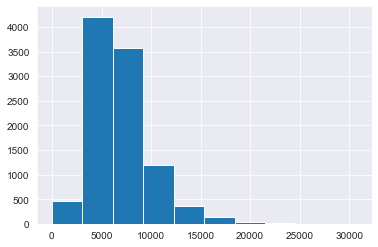

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(merged_df.Sales.sample(10000));

**2. Tunning Hyperparameter**

**model1**

In [145]:
model1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.1, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

In [146]:
%%time
model1.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 37min 16s, sys: 2min 14s, total: 39min 31s
Wall time: 5min 11s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [147]:
preds_test1_model1 = model1.predict(X_test1)

In [148]:
rmse(preds_test1_model1, targets_test1)

1202.474995861658

**model2**

In [168]:
model2 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.25, 
                      max_depth=12, 
                      subsample=0.7, 
                      colsample_bytree=0.7)

In [169]:
%%time
model2.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 50min 11s, sys: 2min 33s, total: 52min 44s
Wall time: 13min 12s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.25, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [170]:
preds_test1_model2 = model2.predict(X_test1)

In [171]:
rmse(preds_test1_model2, targets_test1)

1324.5327890450449

**model3**

In [173]:
model3 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.5, 
                      max_depth=15, 
                      subsample=0.8, 
                      colsample_bytree=0.8)

In [174]:
%%time
model3.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 1h 18min 22s, sys: 4min 39s, total: 1h 23min 1s
Wall time: 24min


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [175]:
preds_test1_model3 = model3.predict(X_test1)

In [176]:
rmse(preds_test1_model3, targets_test1)

1491.7187303123446

**model4**

In [177]:
model4 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.75, 
                      max_depth=20, 
                      subsample=0.9, 
                      colsample_bytree=0.9)

In [178]:
%%time
model4.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 54min 53s, sys: 3min 58s, total: 58min 51s
Wall time: 20min 21s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.75, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [179]:
preds_test1_model4 = model4.predict(X_test1)

In [180]:
rmse(preds_test1_model4, targets_test1)

1656.4902844049698

- **It looks like increasing hyperparameter values, models don't performance reduces**
- **Now let's reduce values in hyperparameter**

**model5**

In [185]:
model5 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.05, 
                      max_depth=10, 
                      subsample=0.3, 
                      colsample_bytree=0.3)

In [186]:
%%time
model5.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 19min 58s, sys: 1min 33s, total: 21min 32s
Wall time: 5min 21s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [187]:
preds_test1_model5 = model5.predict(X_test1)

In [188]:
rmse(preds_test1_model5, targets_test1)

1307.2876882806163

**model6: sub_sample, colsample_bytree= 0.4**

In [190]:
model6 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.05, 
                      max_depth=10, 
                      subsample=0.4, 
                      colsample_bytree=0.4)
"""
model1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.1, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

rmse 1202

model2 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.25, 
                      max_depth=12, 
                      subsample=0.7, 
                      colsample_bytree=0.7)
rmse 1324

model5 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.05, 
                      max_depth=10, 
                      subsample=0.3, 
                      colsample_bytree=0.3)
rmse 1307
"""



'\nmodel1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, \n                      learning_rate=0.1, \n                      max_depth=10, \n                      subsample=0.5, \n                      colsample_bytree=0.5)\n\nrmse 1202\n\nmodel2 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, \n                      learning_rate=0.25, \n                      max_depth=12, \n                      subsample=0.7, \n                      colsample_bytree=0.7)\nrmse 1324\n\nmodel5 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, \n                      learning_rate=0.05, \n                      max_depth=10, \n                      subsample=0.3, \n                      colsample_bytree=0.3)\nrmse 1307\n'

In [191]:
%%time
model6.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 25min 10s, sys: 1min 38s, total: 26min 48s
Wall time: 7min 19s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [192]:
preds_test1_model6 = model6.predict(X_test1)

In [193]:
rmse(preds_test1_model6, targets_test1)

1282.53979720896

**model7: reduce learaning rate to 0.01 | compare with model 1**

In [196]:
model7 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.01, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)
"""
model1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.1, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

rmse 1202
"""

'\nmodel1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, \n                      learning_rate=0.1, \n                      max_depth=10, \n                      subsample=0.5, \n                      colsample_bytree=0.5)\n\nrmse 1202\n'

In [197]:
%%time
model7.fit(X_train1, targets_train1)

CPU times: user 33min 31s, sys: 1min 56s, total: 35min 28s
Wall time: 8min 59s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [198]:
preds_test1_model7 = model7.predict(X_test1)

In [199]:
rmse(preds_test1_model7, targets_test1)

1547.2919329153438

**model8: adjust learnining_rate from model1 0.1 to 0.05 **

In [200]:
model8 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.05, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)
"""
model1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.1, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

rmse 1202

"""

'\nmodel1 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, \n                      learning_rate=0.1, \n                      max_depth=10, \n                      subsample=0.5, \n                      colsample_bytree=0.5)\n\nrmse 1202\n\n'

In [201]:
%%time
model8.fit(X_train1, targets_train1)

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 33min 54s, sys: 2min 35s, total: 36min 29s
Wall time: 8min 34s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [202]:
preds_test1_model8 = model8.predict(X_test1)

In [203]:
rmse(preds_test1_model8, targets_test1)

1211.9566154555375

**model9: Adjust model1 learning_rate to 0.2**

In [208]:
model9 = XGBRegressor(random_state=42, n_jobs=-1,
                      n_estimators=1000, 
                      learning_rate=0.2, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

In [209]:
%%time
model9.fit(X_train1, targets_train1)

CPU times: user 34min 1s, sys: 1min 57s, total: 35min 58s
Wall time: 9min 25s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [210]:
preds_test1_model9 = model9.predict(X_test1)

In [211]:
rmse(preds_test1_model9, targets_test1)

1240.0572116452693

**model10**

In [226]:
model10 = XGBRegressor(random_state=42, n_jobs=-1,
                      n_estimators=1500, 
                      learning_rate=0.09, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

In [227]:
%%time
model10.fit(X_train1, targets_train1)

CPU times: user 52min 21s, sys: 3min 15s, total: 55min 37s
Wall time: 14min 7s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.09, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [228]:
preds_test1_model10 = model10.predict(X_test1)

In [229]:
rmse(preds_test1_model10, targets_test1)

1226.5271084864908

### Test Prediction

In [156]:
model_test = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000, 
                      learning_rate=0.1, 
                      max_depth=10, 
                      subsample=0.5, 
                      colsample_bytree=0.5)

In [158]:
%%time
model_test.fit(X_train, targets)

CPU times: user 46min 15s, sys: 2min 50s, total: 49min 6s
Wall time: 6min 26s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
preds_test = model_test.predict(X_test)

In [160]:
preds_test

array([ 4171.1587,  7576.3   ,  9450.201 , ...,  6946.5527, 23244.174 ,
        7664.4053], dtype=float32)

### Submission

In [224]:
submission_df["Sales"] = preds_test

In [225]:
test_df["Open"].value_counts()

1.0    35093
0.0     5984
Name: Open, dtype: int64

In [226]:
test_df["Open"].sample(10)

10971    1.0
24011    1.0
22063    0.0
35722    1.0
23727    1.0
26927    1.0
945      1.0
20210    1.0
35611    1.0
25956    1.0
Name: Open, dtype: float64

In [227]:
submission_df["Sales"].sample(10)

28210     9040.509766
26727     7671.209961
13212     5316.002441
31535     5512.117188
25374    10277.890625
22538     4644.141113
6358      5009.815918
1809      5115.820312
40004     4363.998535
38866    12341.541992
Name: Sales, dtype: float32

- I will replace missing value with 1
- And multiply predicted ["Sales"] with ["Open"] to make the values of Sales when stores close is 1

In [235]:
submission_df["Sales"] = submission_df["Sales"] * test_df["Open"].fillna(1.)

In [236]:
submission_df

,Id,Sales
0,1,4171.158691
1,2,7576.299805
2,3,9450.201172
3,4,7152.576660
4,5,6832.645996
...,...,...
41083,41084,3067.112061
41084,41085,8007.940918
41085,41086,6946.552734
41086,41087,23244.173828


In [237]:
submission_df.isna().sum()

Id       0
Sales    0
dtype: int64

In [238]:
submission_df.to_csv('submission.csv', index=None)